In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from math import ceil

import warnings
#warnings.filterwarnings("ignore")

from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from random import randint

In [2]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":20,"axes.labelsize":15})

In [3]:
df_train = pd.read_csv("df_train_processed.csv")

In [4]:
df_train = df_train.drop(columns=['actor'])

In [6]:
df_train['emotional_intensity'].value_counts()

normal    984
strong    844
Name: emotional_intensity, dtype: int64

## Standardization

In [7]:
df_train_num = df_train.select_dtypes(include="number")
df_train_cat = df_train.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_train_num_scaled = pd.DataFrame(scaler.fit_transform(df_train_num), columns=df_train_num.columns)
df_train = pd.concat([df_train_num_scaled, df_train_cat], axis=1)

In [8]:
df_train_model = df_train

In [9]:
label_encoder = preprocessing.LabelEncoder()
df_train_model['emotional_intensity']= label_encoder.fit_transform(df_train_model['emotional_intensity'])

In [10]:
df_train_model = pd.get_dummies(df_train_model)

In [11]:
df_emotional_intensity_train = df_train_model

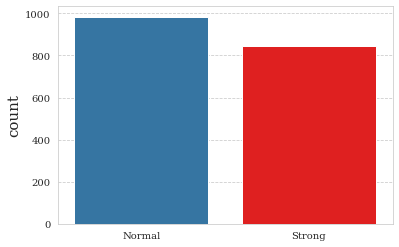

In [168]:
labels = ['Normal','Strong']
ax=sns.countplot(x=df_emotional_intensity_train['emotional_intensity'], palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
ax.set(xlabel=None)
img_name = 'Before_Imbalancing_Emotional_Intensity' + '.png'
plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

In [12]:
X = np.array(df_emotional_intensity_train.loc[:, df_emotional_intensity_train.columns != 'emotional_intensity'])
    
y = np.array(df_emotional_intensity_train.loc[:, df_emotional_intensity_train.columns == 'emotional_intensity'])

In [13]:
np.unique(y, return_counts=True)

(array([0, 1]), array([984, 844]))

In [14]:
import random
random.seed(2)
rows2remove = np.random.choice(df_emotional_intensity_train[y == 0].index, 984-35, replace=False)

In [15]:
df2 = df_emotional_intensity_train.drop(index=rows2remove, axis=0)
print(len(df2))

879


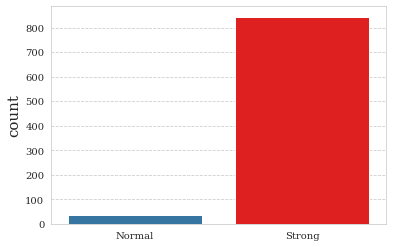

In [169]:
labels = ['Normal','Strong']
ax=sns.countplot(x=df2['emotional_intensity'], palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
ax.set(xlabel=None)
img_name = 'After_Imbalancing_Emotional_Intensity' + '.png'
plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

In [16]:
X2 = np.array(df2.loc[:, df2.columns != 'emotional_intensity'])
y2 = np.array([y[i] for i in range(len(y)) if i not in rows2remove]).ravel()

In [17]:
y2 = np.select([y2 == 1, y2 == 0], [0, 1], y2)

In [18]:
np.unique(y2, return_counts=True)        #majority class strong

(array([0, 1]), array([844,  35]))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=100)

In [20]:
X_train.shape

(615, 390)

In [162]:
def perform_tsne(X_data, y_data,img_name_prefix):
        
   
        X_reduced = TSNE(random_state=42).fit_transform(X_data)
     
        
       
        df = pd.DataFrame({'Dim 1':X_reduced[:,0], 'Dim 2':X_reduced[:,1] ,'label':y_data})
        
      
        
        sns.lmplot(data=df, x='Dim 2', y='Dim 1', hue='label', fit_reg=False, height=8,legend=False,
                   palette='Set1')
      
        plt.legend( loc='upper right', labels=['strong', 'normal'])
        img_name = img_name_prefix + '.png'
       
       
        plt.savefig(img_name,dpi=300, bbox_inches='tight')
        plt.show()
        

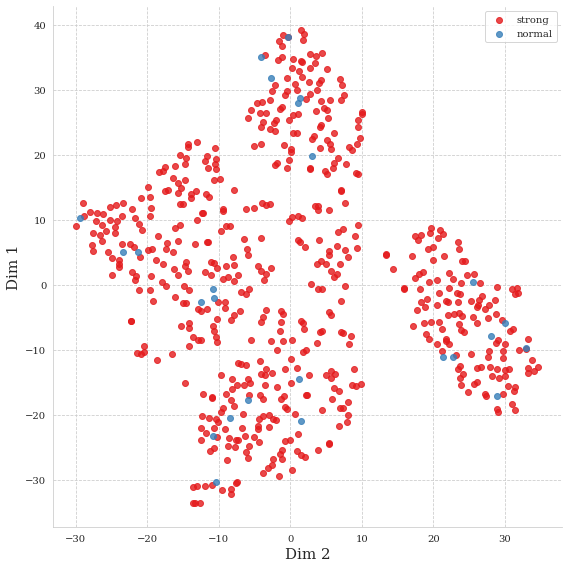

In [163]:
perform_tsne( X_train , y_train, 'Imbalance_Emotional_Intensity')

## Decision Tree before Undersampling/Oversampling

In [24]:
from scipy.stats import uniform, randint, loguniform
from sklearn.model_selection import RepeatedStratifiedKFold

In [25]:
def Decision_tree(X_train_array, y_train_array):
    param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": randint(2, 200),
    "criterion": ["gini", "entropy", "log_loss"],
    
}


    tree = DecisionTreeClassifier(random_state=42)


    tree_cv = RandomizedSearchCV(tree, param_grid, cv=RepeatedStratifiedKFold(n_splits=10,random_state=42),
    n_jobs=-1,
    n_iter=200)


    tree_cv.fit(X_train_array,y_train_array)

    return tree_cv

In [26]:
decision_tree = Decision_tree(X_train, y_train)

In [27]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 182, 'min_samples_leaf': 0.07569869353261265, 'min_samples_split': 0.13584538028414128}


In [28]:
y_pred_decision_tree = decision_tree.predict(X_test)

In [29]:
def metrics_model( test,predict, majority_class, minority_class):
    new_dic = {}
    new_dic['accuracy'] = accuracy_score(test,predict)
    #new_dic['precision ('+ majority_class + ')'] = precision_score(predict, test, average=None)[0]
    #new_dic['precision ('+ minority_class + ')'] = precision_score(predict, test,average=None)[1]
    #new_dic['recall ('+ majority_class + ')'] = recall_score(predict, test, average=None)[0]
    #new_dic['recall ('+ minority_class + ')'] = recall_score(predict, test, average=None)[1]
    new_dic['f1_score ('+ majority_class + ')'] = f1_score(test,predict, average=None)[0]
    new_dic['f1_score ('+ minority_class + ')'] = f1_score(test,predict, average=None)[1]
    
    return new_dic

In [136]:
data_decision_tree = metrics_model( y_test, y_pred_decision_tree, 'strong', 'normal')
data_decision_tree

{'accuracy': 0.9621212121212122,
 'f1_score (strong)': 0.9806949806949807,
 'f1_score (normal)': 0.0}

In [137]:
print(classification_report(y_test, y_pred_decision_tree))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       254
           1       0.00      0.00      0.00        10

    accuracy                           0.96       264
   macro avg       0.48      0.50      0.49       264
weighted avg       0.93      0.96      0.94       264



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

## KNN before Undersampling/Oversampling

In [32]:
def spearman_selector(target, df, k):
    """Returns a df comprising all the features highly correlated (above k and below -k)
    with the binary target according Spearman coefficient. Target must be a pd Series"""
    df = df.select_dtypes(include="number")
    target = target.map({target.unique()[0]:0, target.unique()[1]:1})
    new_df = pd.DataFrame()
    for col in df:
        spearman = stats.spearmanr(df[col], target)[0]
        if spearman > k or spearman < -k:
            new_df[col] = df[col]
    return new_df

In [33]:
df_emotional_intensity_train_knn = spearman_selector(df_train['emotional_intensity'], 
                                           df_train, 0.4)

In [34]:
df_train_cat_knn = df_train.select_dtypes(include=['object'])
df_emotional_intensity_train = pd.concat([df_emotional_intensity_train_knn, df_train_cat_knn], axis=1)

In [35]:
df_emotional_intensity_train = pd.get_dummies(df_emotional_intensity_train)

In [36]:
X3 = np.array(df_emotional_intensity_train.loc[:, df_emotional_intensity_train.columns != 'emotional_intensity'])
    
y3 = np.array(df_emotional_intensity_train.loc[:, df_emotional_intensity_train.columns == 'emotional_intensity'])

In [37]:
np.unique(y3, return_counts=True)

(array([0, 1]), array([984, 844]))

In [38]:
import random
random.seed(2)
rows2remove1 = np.random.choice(df_emotional_intensity_train[y == 0].index, 984-35, replace=False)

In [39]:
df3 = df_emotional_intensity_train.drop(index=rows2remove1, axis=0)
print(len(df3))

879


In [52]:
X4 = np.array(df3.loc[:, df3.columns != 'emotional_intensity'])
y4 = np.array([y[i] for i in range(len(y)) if i not in rows2remove1]).ravel()

In [53]:
np.unique(y4, return_counts=True)   #majority class strong

(array([0, 1]), array([ 35, 844]))

In [54]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X4, y4, test_size=0.3, random_state=100)

In [55]:
X_train_knn.shape

(615, 21)

In [56]:
def Knn(X_train_array, y_train_array):  
    
    knn = KNeighborsClassifier()
    
    parameters = {
        'n_neighbors': np.arange(2, X_train_array.shape[0]//2),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'cityblock', 'minkowski']
        }
    
    knn_cv = RandomizedSearchCV(knn,
                     parameters,
                    cv=RepeatedStratifiedKFold(n_splits=10,random_state=42),
                    n_jobs=-1,
                    refit=True,random_state=24)
    
    knn_cv.fit(X_train_array, y_train_array)
    
    return knn_cv

In [57]:
knn = Knn(X_train_knn, y_train_knn)

In [58]:
print(knn.best_params_)

{'weights': 'uniform', 'n_neighbors': 211, 'metric': 'euclidean'}


In [59]:
y_pred_knn = knn.predict(X_test_knn)

In [60]:
data_knn = metrics_model(y_test_knn, y_pred_knn, 'normal', 'strong')
data_knn

{'accuracy': 0.9696969696969697,
 'f1_score (normal)': 0.0,
 'f1_score (strong)': 0.9846153846153847}

In [61]:
print(classification_report(y_test_knn, y_pred_knn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.97      1.00      0.98       256

    accuracy                           0.97       264
   macro avg       0.48      0.50      0.49       264
weighted avg       0.94      0.97      0.95       264



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [138]:
def combined_results(data,data1):
    combined_dic = {'Decision_tree': data, 'Knn':data1}
    
    return combined_dic

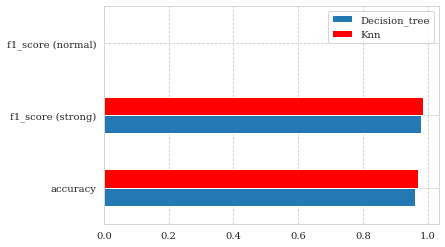

In [164]:
combined_dic = combined_results(data_decision_tree,data_knn)
df = pd.DataFrame(combined_dic)
df.plot(kind='barh', color=['#2478b4','red'])
plt.savefig('Imbalanced_Emotional_Intensity_Result',dpi=300, bbox_inches='tight')
plt.show()

## Undersampling

## Random Undersampling

In [64]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours

In [65]:
def randomUnderSampler(X_train_array, y_train_array):
    
    
    rus = RandomUnderSampler(random_state=42)
    
    X_res_rus, y_res_rus = rus.fit_resample(X_train_array, y_train_array)
    
    return X_res_rus, y_res_rus

In [66]:
X_res_rus, y_res_rus = randomUnderSampler(X_train, y_train)

In [67]:
X_res_rus_knn, y_res_rus_knn = randomUnderSampler(X_train_knn, y_train_knn)

In [68]:
print('Resampled dataset shape %s' % Counter(y_res_rus))

Resampled dataset shape Counter({0: 25, 1: 25})


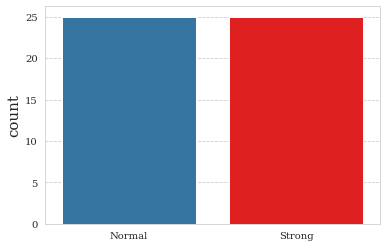

In [69]:
labels = ['Normal','Strong']
ax=sns.countplot(x=y_res_rus, palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
img_name = 'RandomUndersampling_Emotional_Intensity' + '.png'
plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

## KNN after Random Undersampling

In [70]:
knn_under_rus = Knn(X_res_rus_knn, y_res_rus_knn)

In [71]:
print(knn_under_rus.best_params_)

{'weights': 'distance', 'n_neighbors': 6, 'metric': 'cityblock'}


In [72]:
y_pred_knn_under_rus = knn_under_rus.predict(X_test_knn)

In [140]:
knn_rus = metrics_model(y_test_knn, y_pred_knn_under_rus, 'normal', 'strong')
knn_rus

{'accuracy': 0.5643939393939394,
 'f1_score (normal)': 0.08000000000000002,
 'f1_score (strong)': 0.7146401985111662}

In [141]:
print(classification_report(y_test_knn, y_pred_knn_under_rus))

              precision    recall  f1-score   support

           0       0.04      0.62      0.08         8
           1       0.98      0.56      0.71       256

    accuracy                           0.56       264
   macro avg       0.51      0.59      0.40       264
weighted avg       0.95      0.56      0.70       264



## Decision Tree after Random Undersampling

In [75]:
decision_tree_under_rus = Decision_tree(X_res_rus, y_res_rus)

In [76]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_under_rus.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 34, 'min_samples_leaf': 0.10302346718332629, 'min_samples_split': 0.7687236004813283}


In [77]:
y_pred_decision_tree_under_rus = decision_tree_under_rus.predict(X_test)

In [144]:
decision_tree_rus = metrics_model(y_test, y_pred_decision_tree_under_rus, 'strong', 'normal')
decision_tree_rus

{'accuracy': 0.5681818181818182,
 'f1_score (strong)': 0.7106598984771574,
 'f1_score (normal)': 0.1492537313432836}

In [145]:
print(classification_report(y_test, y_pred_decision_tree_under_rus))

              precision    recall  f1-score   support

           0       1.00      0.55      0.71       254
           1       0.08      1.00      0.15        10

    accuracy                           0.57       264
   macro avg       0.54      0.78      0.43       264
weighted avg       0.97      0.57      0.69       264



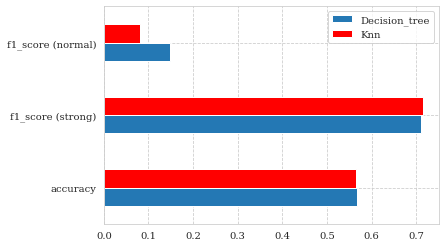

In [147]:
combined_dic_rus = combined_results(decision_tree_rus,knn_rus)
df = pd.DataFrame(combined_dic_rus)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.legend('loc=l', bbox_to_anchor=(0.6,0.5), labels=['Decision Tree', 'KNN'])
plt.savefig('RandomUndersampling_Emotional_Intensity_Result',dpi=300, bbox_inches='tight')
plt.show()

## Edited Nearest Neighbors

In [96]:
def enn(X_train_array, y_train_array):
    
    enn = EditedNearestNeighbours()
    
    X_res_enn, y_res_enn = enn.fit_resample(X_train_array, y_train_array)
    
    return X_res_enn, y_res_enn

In [97]:
X_res_enn, y_res_enn = enn(X_train, y_train)

In [98]:
X_res_enn_knn, y_res_enn_knn = enn(X_train_knn, y_train_knn)

In [99]:
print('Resampled dataset shape %s' % Counter(y_res_enn))

Resampled dataset shape Counter({0: 536, 1: 25})


## KNN after Edited Nearest Neighbors

In [100]:
knn_under_enn = Knn(X_res_enn_knn, y_res_enn_knn)

In [101]:
print(knn_under_enn.best_params_)

{'weights': 'distance', 'n_neighbors': 12, 'metric': 'minkowski'}


In [102]:
y_pred_knn_under_enn = knn_under_enn.predict(X_test_knn)

In [148]:
knn_enn = metrics_model(y_test_knn,y_pred_knn_under_enn, 'normal', 'strong')
knn_enn

{'accuracy': 0.9545454545454546,
 'f1_score (normal)': 0.0,
 'f1_score (strong)': 0.9767441860465116}

In [150]:
print(classification_report(y_test_knn, y_pred_knn_under_enn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.97      0.98      0.98       256

    accuracy                           0.95       264
   macro avg       0.48      0.49      0.49       264
weighted avg       0.94      0.95      0.95       264



## Decision Tree after Edited Nearest Neighbors

In [105]:
decision_tree_under_enn = Decision_tree(X_res_enn, y_res_enn)

In [106]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_under_enn.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'log_loss', 'max_depth': 35, 'min_samples_leaf': 0.06390321438486415, 'min_samples_split': 0.020348043209069674}


In [107]:
y_pred_decision_tree_under_enn = decision_tree_under_enn.predict(X_test)

In [151]:
decision_tree_enn = metrics_model(y_test, y_pred_decision_tree_under_enn, 'strong', 'normal')
decision_tree_enn

{'accuracy': 0.9621212121212122,
 'f1_score (strong)': 0.9806949806949807,
 'f1_score (normal)': 0.0}

In [152]:
print(classification_report(y_test, y_pred_decision_tree_under_enn))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       254
           1       0.00      0.00      0.00        10

    accuracy                           0.96       264
   macro avg       0.48      0.50      0.49       264
weighted avg       0.93      0.96      0.94       264



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

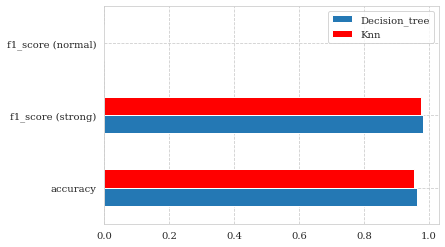

In [153]:
combined_dic_enn = combined_results(decision_tree_enn,knn_enn)
df = pd.DataFrame(combined_dic_enn)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.savefig('dddd',dpi=300, bbox_inches='tight')
plt.show()

## Oversampling

## SMOTE

In [111]:
from imblearn.over_sampling import SMOTE

In [112]:
def smote(X_train_array, y_train_array):
    
    sm = SMOTE(random_state=42)
    
    X_res_sm, y_res_sm = sm.fit_resample(X_train_array, y_train_array)
    
    return X_res_sm, y_res_sm

In [113]:
X_res_sm_knn, y_res_sm_knn = smote(X_train_knn, y_train_knn)

In [114]:
X_res_sm, y_res_sm = smote(X_train, y_train)

In [115]:
print('Resampled dataset shape %s' % Counter(y_res_sm))

Resampled dataset shape Counter({0: 590, 1: 590})


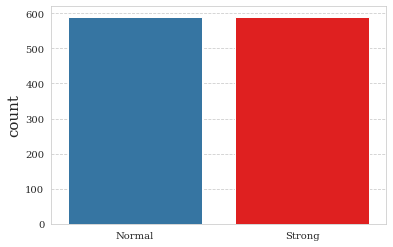

In [117]:
labels = ['Normal','Strong']
ax=sns.countplot(x=y_res_sm, palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
img_name = 'SMOTE_Emotional_Intensity' + '.png'
plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

## KNN after SMOTE

In [118]:
knn_over_sm = Knn(X_res_sm_knn, y_res_sm_knn)

In [119]:
print(knn_over_sm.best_params_)

{'weights': 'distance', 'n_neighbors': 63, 'metric': 'euclidean'}


In [120]:
y_pred_knn_over_sm = knn_over_sm.predict(X_test_knn)

In [154]:
knn_smote = metrics_model(y_test_knn, y_pred_knn_over_sm, 'normal', 'strong')
knn_smote

{'accuracy': 0.7462121212121212,
 'f1_score (normal)': 0.08219178082191782,
 'f1_score (strong)': 0.8527472527472528}

In [155]:
print(classification_report(y_test_knn, y_pred_knn_over_sm))

              precision    recall  f1-score   support

           0       0.05      0.38      0.08         8
           1       0.97      0.76      0.85       256

    accuracy                           0.75       264
   macro avg       0.51      0.57      0.47       264
weighted avg       0.95      0.75      0.83       264



## Decision Tree after SMOTE

In [123]:
decision_tree_over_sm = Decision_tree(X_res_sm, y_res_sm)

In [124]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_over_sm.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 39, 'min_samples_leaf': 0.002345155410713517, 'min_samples_split': 0.0363421661591107}


In [125]:
y_pred_decision_tree_over_sm = decision_tree_over_sm.predict(X_test)

In [156]:
decision_tree_smote = metrics_model(y_test, y_pred_decision_tree_over_sm, 'strong', 'normal')
decision_tree_smote

{'accuracy': 0.8825757575757576,
 'f1_score (strong)': 0.9368635437881874,
 'f1_score (normal)': 0.16216216216216217}

In [157]:
print(classification_report(y_test, y_pred_decision_tree_over_sm))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       254
           1       0.11      0.30      0.16        10

    accuracy                           0.88       264
   macro avg       0.54      0.60      0.55       264
weighted avg       0.94      0.88      0.91       264



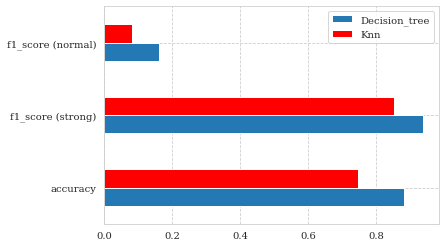

In [159]:
combined_dic_smote = combined_results(decision_tree_smote,knn_smote)
df = pd.DataFrame(combined_dic_smote)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.legend('loc=l', bbox_to_anchor=(0.6,0.5), labels=['Decision Tree', 'KNN'])
plt.savefig('SMOTE_Emotional_Intensity_Result',dpi=300, bbox_inches='tight')
plt.show()